<a href="https://colab.research.google.com/github/staerkjoe/ML_colab/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## a. Preparation
- Load pretrained CLIP model (ViT-B/32)
- Prepare example images and corresponding text prompts

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision transformers ftfy regex tqdm
!pip install accelerate

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel

# Load pretrained CLIP (text + image encoders)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)
print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Using device: cuda


## Prepare Images and Text Prompts

In [4]:
from PIL import Image

# Define text prompts
text_prompts = [
    "a photo of a red apple",
    "a photo of a dog",
    "a photo of a horse",
    "a photo of an airplane"
]

# Load corresponding images (update paths as needed)
images = [
    Image.open("/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/redapple.jpg"),
    Image.open("/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/dog.jpg"),
    Image.open("/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/horse.jpg"),
    Image.open("/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/airplane.jpg")
]

print(f"Loaded {len(images)} images and {len(text_prompts)} text prompts")

Loaded 4 images and 4 text prompts


## b. Encode Images and Text
Compute feature embeddings using CLIP encoders and normalize them (L2 normalization).

In [5]:
# Process inputs
inputs = clip_processor(text=text_prompts, images=images, return_tensors="pt", padding=True).to(device)

# Get embeddings
with torch.no_grad():
    image_features = clip_model.get_image_features(pixel_values=inputs['pixel_values'])
    text_features = clip_model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # Normalize embeddings (L2 normalization)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Check vector shapes and confirm unit length
    print(f"Image features shape: {image_features.shape}")
    print(f"Text features shape: {text_features.shape}")
    print(f"Image features norm (should be ~1.0): {image_features.norm(dim=-1)}")
    print(f"Text features norm (should be ~1.0): {text_features.norm(dim=-1)}")

Image features shape: torch.Size([4, 512])
Text features shape: torch.Size([4, 512])
Image features norm (should be ~1.0): tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')
Text features norm (should be ~1.0): tensor([1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')


## c. Compute Cosine Similarities
Calculate the similarity matrix between all pairs of image and text embeddings.

In [6]:
# Compute similarity matrix (cosine similarity via dot product of normalized vectors)
similarity_matrix = image_features @ text_features.T

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"\nSimilarity matrix (rows=images, columns=texts):")
print(similarity_matrix.cpu().numpy())

Similarity matrix shape: torch.Size([4, 4])

Similarity matrix (rows=images, columns=texts):
[[0.32664979 0.23130187 0.22866313 0.20917676]
 [0.1795187  0.27007878 0.20070028 0.16999607]
 [0.2095011  0.21882087 0.30764288 0.1993011 ]
 [0.1465654  0.1670774  0.17538439 0.2435412 ]]


## Visualize Similarity Matrix
Display the similarity scores as a heatmap. Diagonal values should be highest (matching pairs).

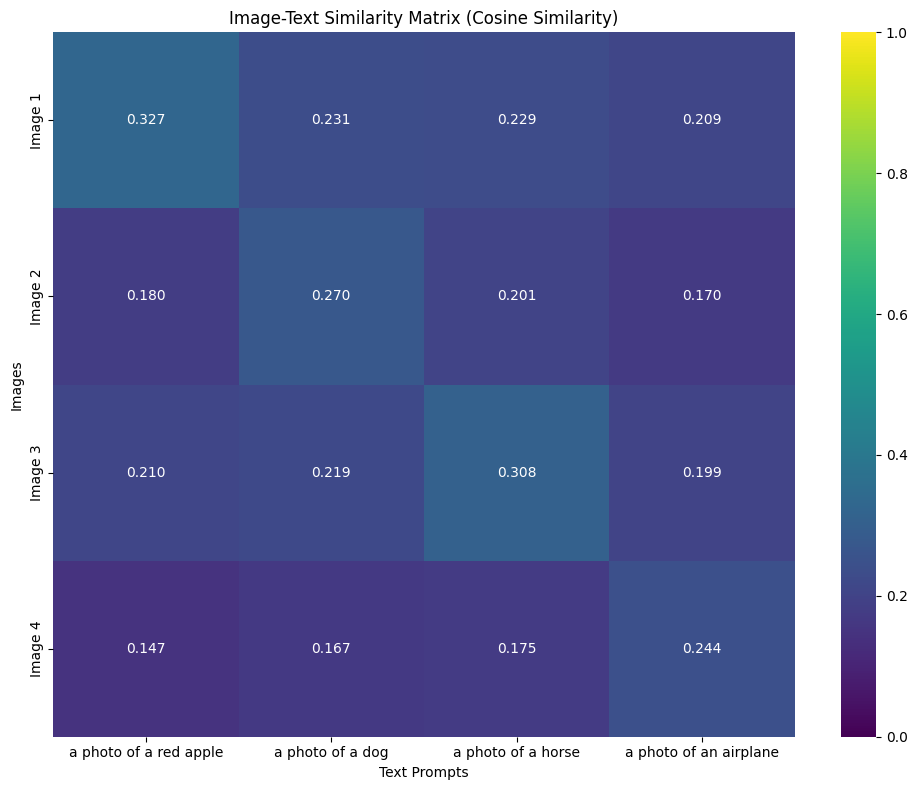

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.cpu().numpy(), annot=True, fmt='.3f',
            xticklabels=text_prompts,
            yticklabels=[f'Image {i+1}' for i in range(len(images))],
            cmap='viridis', vmin=0, vmax=1)
plt.title('Image-Text Similarity Matrix (Cosine Similarity)')
plt.xlabel('Text Prompts')
plt.ylabel('Images')
plt.tight_layout()
plt.show()

## Analysis
**Expected Results:** The diagonal values should be highest, indicating that each image best matches its corresponding text prompt. This demonstrates CLIP's ability to align vision and language in a shared embedding space.

In [8]:
# Find best matching text for each image
for i, img_feat in enumerate(image_features):
    similarities = (img_feat @ text_features.T).cpu().numpy()
    best_match_idx = similarities.argmax()
    print(f"Image {i+1} best matches: '{text_prompts[best_match_idx]}' (similarity: {similarities[best_match_idx]:.3f})")

Image 1 best matches: 'a photo of a red apple' (similarity: 0.327)
Image 2 best matches: 'a photo of a dog' (similarity: 0.270)
Image 3 best matches: 'a photo of a horse' (similarity: 0.308)
Image 4 best matches: 'a photo of an airplane' (similarity: 0.244)
